# **Oxford Pets Image Segmentation with U-Net**

## Overview

In this notebook, we’ll build a Convolutional Neural Network based on the U-Net architecture to perform image segmentation on the Oxford Pets dataset.

Following steps:
1. Load and explore the dataset
2. Preprocess the images and masks
3. Define and build the U-Net model
4. Train the model using a learning rate scheduler and early stopping
5. Visualize the model's performance with sample predictions

### 1. Import Libraries

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pandas as pd
import random
from tensorflow.keras.utils import array_to_img
from PIL import Image
import cv2
import warnings
warnings.filterwarnings("ignore")

2024-11-15 03:52:56.712830: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-15 03:52:56.721071: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-15 03:52:56.729840: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-15 03:52:56.732419: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 03:52:56.739992: I tensorflow/core/platform/cpu_feature_guar


### 2. Download and Prepare the Dataset
Download the Oxford-IIIT Pet dataset.


In [ ]:
# Download and extract the dataset
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2024-11-15 03:52:19--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2024-11-15 03:52:20--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2024-11-15 03:52:21--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [app

In [2]:
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

In [3]:
input_dir = "images/"
target_dir = "annotations/trimaps/"


In [4]:
if not os.path.exists(input_dir):
    print(f"Input directory does not exist: {input_dir}")
else:
    input_img_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(".jpg")])
    print(f"Found {len(input_img_paths)} input images.")

if not os.path.exists(target_dir):
    print(f"Target directory does not exist: {target_dir}")
else:
    target_img_paths = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith(".png") and not fname.startswith(".")])
    print(f"Found {len(target_img_paths)} target images.")

Found 7390 input images.
Found 7390 target images.


### 3. Define Image and Target Paths
Load and sort the image and mask paths.

In [5]:
input_img_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(".jpg")])
target_img_paths = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith(".png") and not fname.startswith(".")])

In [6]:
print(len(input_img_paths))
print(len(target_img_paths))

7390
7390


### 4. Display Sample Images and Mask

Display a sample image and its corresponding segmentation mask.

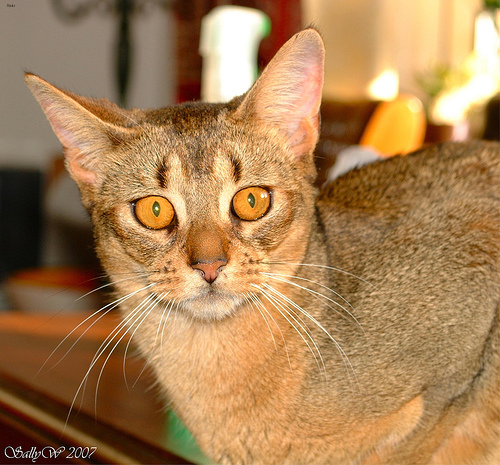

In [7]:
load_img(input_img_paths[4])

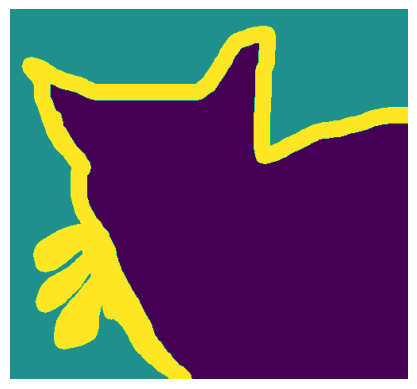

In [8]:
def display_target(img):
    normalized_img = (img.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_img[:, :, 0])

img = load_img(target_img_paths[4], color_mode='grayscale')
img = img_to_array(img)
display_target(img)

### 5. Define Preprocessing Functions

Define helper functions for loading, resizing, and normalizing images and masks.

In [9]:
img_size = (256, 256)

In [10]:
def path_to_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0
    return img

In [11]:
def path_to_target(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.uint8) - 1
    return img

In [12]:
def map_fn(img_path, target_path):
    img = path_to_img(img_path)
    mask = path_to_target(target_path)
    return img, mask

### 6. Data Augmentation

Apply data augmentation techniques like flipping, adjusting brightness, and contrast.


In [13]:
def augment_data(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, mask

### 7. Prepare Dataset

Prepare the datasets for training and validation, applying augmentation only to the training set.

In [14]:
def prepare_dataset(image_paths, mask_paths, batch_size, should_augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)
    if should_augment:
        dataset = dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [15]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available for TensorFlow.")
else:
    print("GPU is not available for TensorFlow.")

GPU is available for TensorFlow.


I0000 00:00:1731630214.253184   12400 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731630214.277959   12400 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731630214.278004   12400 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [16]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [17]:
num_valid_samples = 1000
train_dataset = prepare_dataset(input_img_paths[:-num_valid_samples], 
                                target_img_paths[:-num_valid_samples], 
                                batch_size=3, should_augment=True)

valid_dataset = prepare_dataset(input_img_paths[-num_valid_samples:], 
                                target_img_paths[-num_valid_samples:], 
                                batch_size=3, should_augment=False)

I0000 00:00:1731630217.288346   12400 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731630217.288421   12400 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731630217.288441   12400 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731630217.992819   12400 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731630217.992894   12400 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-15

### 8. Build the U-Net Model

The U-Net model consists of an encoder and a decoder.


In [18]:
def unet_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = layers.concatenate([up5, conv3])
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = layers.UpSampling2D(size=(2, 2))(conv5)
    up6 = layers.concatenate([up6, conv2])
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = layers.UpSampling2D(size=(2, 2))(conv6)
    up7 = layers.concatenate([up7, conv1])
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(conv7)

    model = Model(inputs=inputs, outputs=outputs)

    return model

num_classes = 3
model = unet_model(img_size, num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_9[0][0]  

 Total params: 7,783,043 (29.69 MB)

 Trainable params: 7,783,043 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

### Step 9. Compile the Model with Optimizer and Early Stopping.

In [19]:
initial_learning_rate = 1e-4

optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation_unet.keras", save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                      factor=0.5,
                                      patience=5,
                                      min_lr=1e-6,
                                      verbose=1),
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]

history = model.fit(train_dataset,
                    epochs=60,
                    callbacks=callbacks,
                    validation_data=valid_dataset)

Epoch 1/60


I0000 00:00:1731630223.976468   12656 service.cc:146] XLA service 0x7f4afc004a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731630223.976506   12656 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-11-15 03:53:44.028137: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1731630224.126857   12656 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-11-15 03:53:44.252838: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-11-15 03:53:50.631635: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.10GiB with freed_by_count=0. The caller indicates t

   2/2130 ━━━━━━━━━━━━━━━━━━━━ 2:57 83ms/step - accuracy: 0.1353 - loss: 1.1058  

I0000 00:00:1731630234.139694   12656 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 990/2130 ━━━━━━━━━━━━━━━━━━━━ 1:29 78ms/step - accuracy: 0.6179 - loss: 0.8548

Corrupt JPEG data: premature end of data segment


1126/2130 ━━━━━━━━━━━━━━━━━━━━ 1:19 79ms/step - accuracy: 0.6231 - loss: 0.8460

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6536 - loss: 0.7905

W0000 00:00:1731630402.126578   12656 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-11-15 03:56:43.058864: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-15 03:56:43.550116: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.24GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-15 03:56:43.901662: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.32GiB with freed_by_count=0. The caller in

2130/2130 ━━━━━━━━━━━━━━━━━━━━ 193s 85ms/step - accuracy: 0.6537 - loss: 0.7904 - val_accuracy: 0.6577 - val_loss: 0.7910 - learning_rate: 1.0000e-04
Epoch 2/60
 990/2130 ━━━━━━━━━━━━━━━━━━━━ 1:29 79ms/step - accuracy: 0.7614 - loss: 0.5915

Corrupt JPEG data: premature end of data segment


1126/2130 ━━━━━━━━━━━━━━━━━━━━ 1:19 79ms/step - accuracy: 0.7629 - loss: 0.5881

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 176s 83ms/step - accuracy: 0.7726 - loss: 0.5656 - val_accuracy: 0.7562 - val_loss: 0.6242 - learning_rate: 1.0000e-04
Epoch 3/60
 990/2130 ━━━━━━━━━━━━━━━━━━━━ 1:31 81ms/step - accuracy: 0.8043 - loss: 0.4999

Corrupt JPEG data: premature end of data segment


1126/2130 ━━━━━━━━━━━━━━━━━━━━ 1:19 79ms/step - accuracy: 0.8050 - loss: 0.4977

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 177s 83ms/step - accuracy: 0.8108 - loss: 0.4823 - val_accuracy: 0.7844 - val_loss: 0.5373 - learning_rate: 1.0000e-04
Epoch 4/60
 990/2130 ━━━━━━━━━━━━━━━━━━━━ 1:31 80ms/step - accuracy: 0.8257 - loss: 0.4493

Corrupt JPEG data: premature end of data segment


1116/2130 ━━━━━━━━━━━━━━━━━━━━ 1:21 81ms/step - accuracy: 0.8261 - loss: 0.4478

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 178s 83ms/step - accuracy: 0.8309 - loss: 0.4349 - val_accuracy: 0.7941 - val_loss: 0.5060 - learning_rate: 1.0000e-04
Epoch 5/60
 990/2130 ━━━━━━━━━━━━━━━━━━━━ 1:29 79ms/step - accuracy: 0.8400 - loss: 0.4123

Corrupt JPEG data: premature end of data segment


1126/2130 ━━━━━━━━━━━━━━━━━━━━ 1:19 79ms/step - accuracy: 0.8403 - loss: 0.4114

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 176s 82ms/step - accuracy: 0.8440 - loss: 0.4021 - val_accuracy: 0.7826 - val_loss: 0.5695 - learning_rate: 1.0000e-04
Epoch 6/60
 990/2130 ━━━━━━━━━━━━━━━━━━━━ 1:29 78ms/step - accuracy: 0.8487 - loss: 0.3942

Corrupt JPEG data: premature end of data segment


1126/2130 ━━━━━━━━━━━━━━━━━━━━ 1:19 79ms/step - accuracy: 0.8493 - loss: 0.3925

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 176s 82ms/step - accuracy: 0.8534 - loss: 0.3809 - val_accuracy: 0.8309 - val_loss: 0.4219 - learning_rate: 1.0000e-04
Epoch 7/60
 990/2130 ━━━━━━━━━━━━━━━━━━━━ 1:31 80ms/step - accuracy: 0.8567 - loss: 0.3714

Corrupt JPEG data: premature end of data segment


1126/2130 ━━━━━━━━━━━━━━━━━━━━ 1:19 79ms/step - accuracy: 0.8571 - loss: 0.3702

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 176s 83ms/step - accuracy: 0.8608 - loss: 0.3608 - val_accuracy: 0.8188 - val_loss: 0.4550 - learning_rate: 1.0000e-04
Epoch 8/60
 990/2130 ━━━━━━━━━━━━━━━━━━━━ 1:31 80ms/step - accuracy: 0.8608 - loss: 0.3623

Corrupt JPEG data: premature end of data segment


1118/2130 ━━━━━━━━━━━━━━━━━━━━ 1:21 81ms/step - accuracy: 0.8614 - loss: 0.3610

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 177s 83ms/step - accuracy: 0.8656 - loss: 0.3499 - val_accuracy: 0.8229 - val_loss: 0.4517 - learning_rate: 1.0000e-04
Epoch 9/60
 990/2130 ━━━━━━━━━━━━━━━━━━━━ 1:28 78ms/step - accuracy: 0.8670 - loss: 0.3470

Corrupt JPEG data: premature end of data segment


1126/2130 ━━━━━━━━━━━━━━━━━━━━ 1:19 79ms/step - accuracy: 0.8676 - loss: 0.3454

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 175s 82ms/step - accuracy: 0.8717 - loss: 0.3342 - val_accuracy: 0.8423 - val_loss: 0.4048 - learning_rate: 1.0000e-04
Epoch 10/60
 990/2130 ━━━━━━━━━━━━━━━━━━━━ 1:29 78ms/step - accuracy: 0.8742 - loss: 0.3293

Corrupt JPEG data: premature end of data segment


1126/2130 ━━━━━━━━━━━━━━━━━━━━ 1:19 79ms/step - accuracy: 0.8746 - loss: 0.3282

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 175s 82ms/step - accuracy: 0.8780 - loss: 0.3191 - val_accuracy: 0.8472 - val_loss: 0.3942 - learning_rate: 1.0000e-04
Epoch 11/60
 990/2130 ━━━━━━━━━━━━━━━━━━━━ 1:31 80ms/step - accuracy: 0.8769 - loss: 0.3217

Corrupt JPEG data: premature end of data segment


1126/2130 ━━━━━━━━━━━━━━━━━━━━ 1:19 79ms/step - accuracy: 0.8775 - loss: 0.3202

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 175s 82ms/step - accuracy: 0.8814 - loss: 0.3100 - val_accuracy: 0.8668 - val_loss: 0.3456 - learning_rate: 1.0000e-04
Epoch 12/60
 990/2130 ━━━━━━━━━━━━━━━━━━━━ 1:31 80ms/step - accuracy: 0.8812 - loss: 0.3117

Corrupt JPEG data: premature end of data segment


1126/2130 ━━━━━━━━━━━━━━━━━━━━ 1:20 80ms/step - accuracy: 0.8817 - loss: 0.3102

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 176s 83ms/step - accuracy: 0.8853 - loss: 0.3002 - val_accuracy: 0.8512 - val_loss: 0.4081 - learning_rate: 1.0000e-04
Epoch 13/60
 990/2130 ━━━━━━━━━━━━━━━━━━━━ 1:29 78ms/step - accuracy: 0.8854 - loss: 0.3024

Corrupt JPEG data: premature end of data segment


1126/2130 ━━━━━━━━━━━━━━━━━━━━ 1:19 79ms/step - accuracy: 0.8858 - loss: 0.3011

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 175s 82ms/step - accuracy: 0.8890 - loss: 0.2917 - val_accuracy: 0.8651 - val_loss: 0.3554 - learning_rate: 1.0000e-04
Epoch 14/60
 990/2130 ━━━━━━━━━━━━━━━━━━━━ 1:29 78ms/step - accuracy: 0.8899 - loss: 0.2896

Corrupt JPEG data: premature end of data segment


1126/2130 ━━━━━━━━━━━━━━━━━━━━ 1:19 79ms/step - accuracy: 0.8903 - loss: 0.2884

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 174s 82ms/step - accuracy: 0.8934 - loss: 0.2799 - val_accuracy: 0.8724 - val_loss: 0.3433 - learning_rate: 1.0000e-04
Epoch 15/60
 991/2130 ━━━━━━━━━━━━━━━━━━━━ 1:13 65ms/step - accuracy: 0.8939 - loss: 0.2792

Corrupt JPEG data: premature end of data segment


1126/2130 ━━━━━━━━━━━━━━━━━━━━ 1:05 65ms/step - accuracy: 0.8942 - loss: 0.2785

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 144s 68ms/step - accuracy: 0.8968 - loss: 0.2714 - val_accuracy: 0.8766 - val_loss: 0.3245 - learning_rate: 1.0000e-04
Epoch 16/60
 990/2130 ━━━━━━━━━━━━━━━━━━━━ 1:13 64ms/step - accuracy: 0.8974 - loss: 0.2713

Corrupt JPEG data: premature end of data segment


1126/2130 ━━━━━━━━━━━━━━━━━━━━ 1:03 63ms/step - accuracy: 0.8977 - loss: 0.2705

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 142s 67ms/step - accuracy: 0.9002 - loss: 0.2630 - val_accuracy: 0.8616 - val_loss: 0.4089 - learning_rate: 1.0000e-04
Epoch 17/60
 990/2130 ━━━━━━━━━━━━━━━━━━━━ 1:13 64ms/step - accuracy: 0.9001 - loss: 0.2635

Corrupt JPEG data: premature end of data segment


1127/2130 ━━━━━━━━━━━━━━━━━━━━ 1:04 65ms/step - accuracy: 0.9005 - loss: 0.2623

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 142s 67ms/step - accuracy: 0.9033 - loss: 0.2543 - val_accuracy: 0.8629 - val_loss: 0.3983 - learning_rate: 1.0000e-04
Epoch 18/60
 991/2130 ━━━━━━━━━━━━━━━━━━━━ 1:13 65ms/step - accuracy: 0.9025 - loss: 0.2572

Corrupt JPEG data: premature end of data segment


1126/2130 ━━━━━━━━━━━━━━━━━━━━ 1:05 65ms/step - accuracy: 0.9030 - loss: 0.2560

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 144s 68ms/step - accuracy: 0.9059 - loss: 0.2477 - val_accuracy: 0.8743 - val_loss: 0.3599 - learning_rate: 1.0000e-04
Epoch 19/60
 984/2130 ━━━━━━━━━━━━━━━━━━━━ 1:14 65ms/step - accuracy: 0.9064 - loss: 0.2464

Corrupt JPEG data: premature end of data segment


1127/2130 ━━━━━━━━━━━━━━━━━━━━ 1:03 64ms/step - accuracy: 0.9067 - loss: 0.2454

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 142s 67ms/step - accuracy: 0.9092 - loss: 0.2387 - val_accuracy: 0.8706 - val_loss: 0.3770 - learning_rate: 1.0000e-04
Epoch 20/60
 990/2130 ━━━━━━━━━━━━━━━━━━━━ 1:13 65ms/step - accuracy: 0.9085 - loss: 0.2402

Corrupt JPEG data: premature end of data segment


1126/2130 ━━━━━━━━━━━━━━━━━━━━ 1:05 65ms/step - accuracy: 0.9088 - loss: 0.2394

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9112 - loss: 0.2329
Epoch 20: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 143s 67ms/step - accuracy: 0.9112 - loss: 0.2329 - val_accuracy: 0.8757 - val_loss: 0.3614 - learning_rate: 1.0000e-04
Epoch 21/60
 990/2130 ━━━━━━━━━━━━━━━━━━━━ 1:13 65ms/step - accuracy: 0.9091 - loss: 0.2380

Corrupt JPEG data: premature end of data segment


1126/2130 ━━━━━━━━━━━━━━━━━━━━ 1:05 65ms/step - accuracy: 0.9096 - loss: 0.2365

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 144s 67ms/step - accuracy: 0.9128 - loss: 0.2277 - val_accuracy: 0.8806 - val_loss: 0.3437 - learning_rate: 5.0000e-05
Epoch 22/60
 977/2130 ━━━━━━━━━━━━━━━━━━━━ 1:14 64ms/step - accuracy: 0.9135 - loss: 0.2268

Corrupt JPEG data: premature end of data segment


1126/2130 ━━━━━━━━━━━━━━━━━━━━ 1:03 63ms/step - accuracy: 0.9141 - loss: 0.2254

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 142s 67ms/step - accuracy: 0.9172 - loss: 0.2169 - val_accuracy: 0.8814 - val_loss: 0.3535 - learning_rate: 5.0000e-05
Epoch 23/60
 990/2130 ━━━━━━━━━━━━━━━━━━━━ 1:13 64ms/step - accuracy: 0.9192 - loss: 0.2122

Corrupt JPEG data: premature end of data segment


1126/2130 ━━━━━━━━━━━━━━━━━━━━ 1:05 65ms/step - accuracy: 0.9195 - loss: 0.2113

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 142s 67ms/step - accuracy: 0.9217 - loss: 0.2053 - val_accuracy: 0.8795 - val_loss: 0.3714 - learning_rate: 5.0000e-05
Epoch 24/60
 991/2130 ━━━━━━━━━━━━━━━━━━━━ 1:12 64ms/step - accuracy: 0.9217 - loss: 0.2060

Corrupt JPEG data: premature end of data segment


1127/2130 ━━━━━━━━━━━━━━━━━━━━ 1:04 64ms/step - accuracy: 0.9220 - loss: 0.2050

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 143s 67ms/step - accuracy: 0.9242 - loss: 0.1987 - val_accuracy: 0.8810 - val_loss: 0.3692 - learning_rate: 5.0000e-05
Epoch 25/60
 990/2130 ━━━━━━━━━━━━━━━━━━━━ 1:12 64ms/step - accuracy: 0.9245 - loss: 0.1977

Corrupt JPEG data: premature end of data segment


1127/2130 ━━━━━━━━━━━━━━━━━━━━ 1:02 63ms/step - accuracy: 0.9248 - loss: 0.1969

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 140s 66ms/step - accuracy: 0.9266 - loss: 0.1919 - val_accuracy: 0.8815 - val_loss: 0.3821 - learning_rate: 5.0000e-05


### Step 10. Visualize Training History

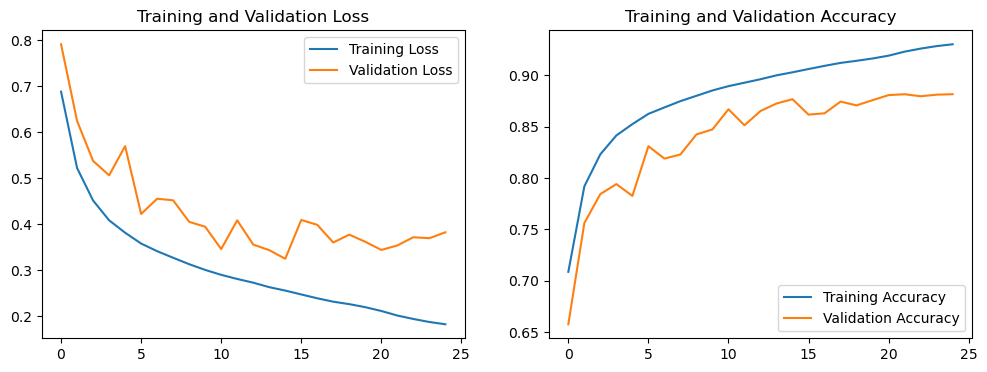

In [20]:
plt.figure(figsize=(12,4))
plt.subplot(1 , 2 ,1 )
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1 , 2 ,2 )
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


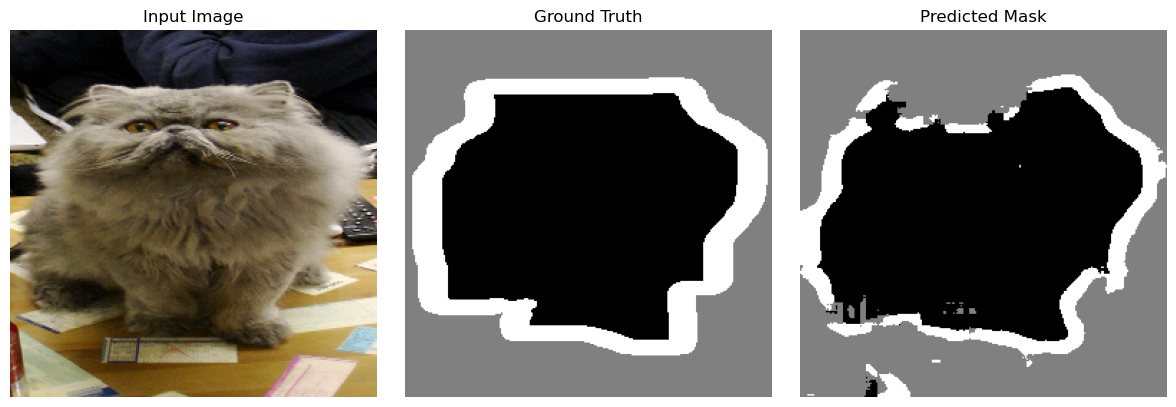

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


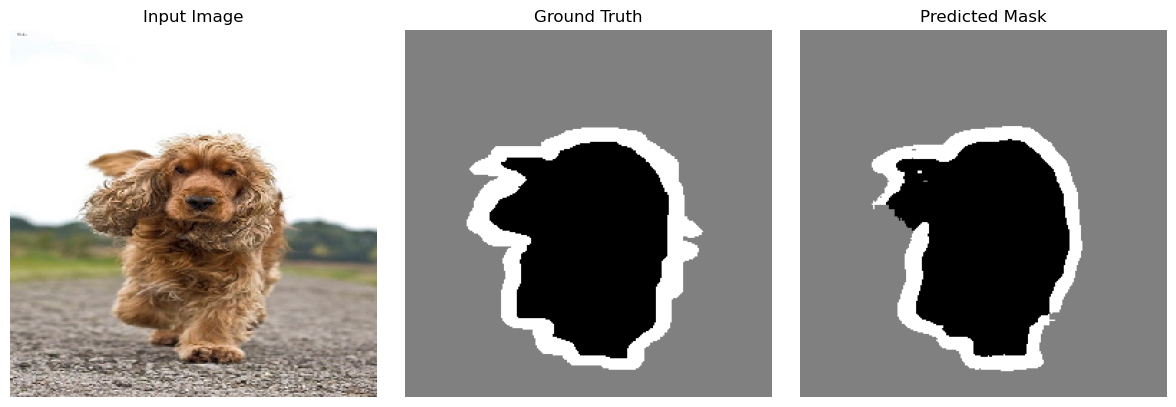

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


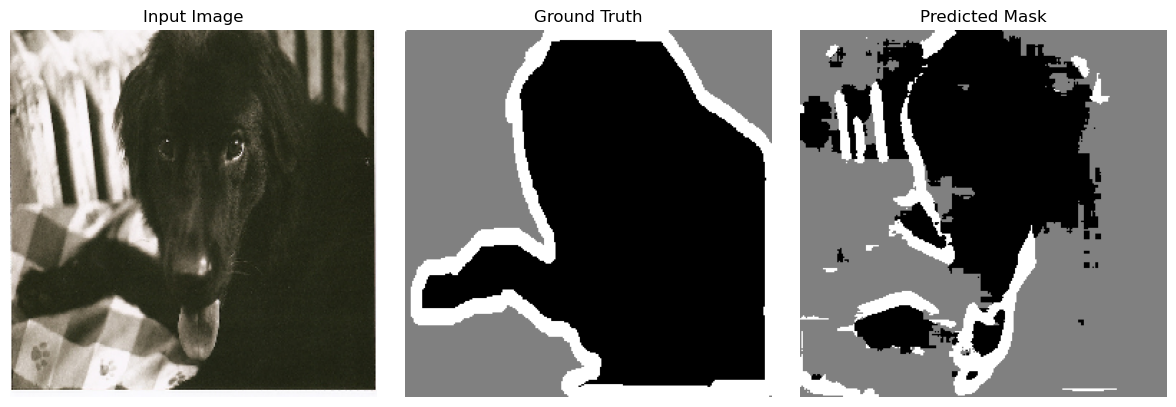

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


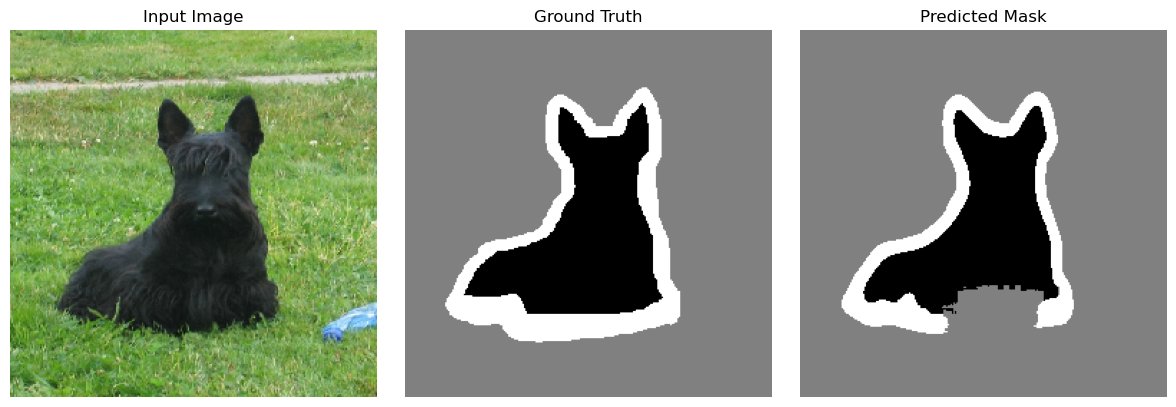

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


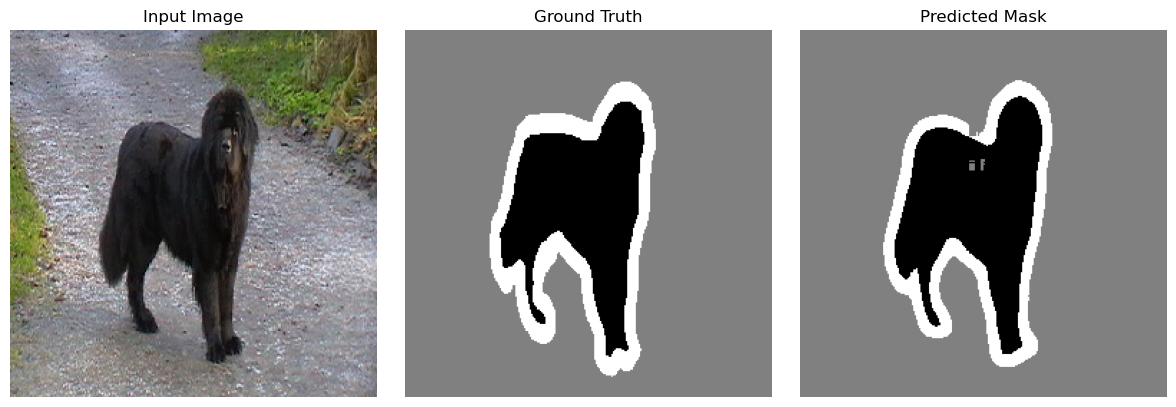

In [24]:
# Load the best model and make predictions
model=keras.models.load_model("oxford_segmentation_unet.keras")

def display_mask(pred):
   mask=np.argmax(pred , axis=-1)
   mask*=127
   return mask

# Visualize predictions
num_display=5
for i in range(num_display):
   idx=np.random.randint(len(input_img_paths))
   test_image=load_img(input_img_paths[idx], target_size=img_size)
   test_image_array=img_to_array(test_image)/255.0

   mask=model.predict(np.expand_dims(test_image_array , axis=0))[0]

   plt.figure(figsize=(12 ,4 ))
   plt.subplot(1 ,3 ,1 )
   plt.title("Input Image")
   plt.imshow(test_image )
   plt.axis("off")

   plt.subplot(1 ,3 ,2 )
   plt.title("Ground Truth")
   gt_mask=load_img(target_img_paths[idx], target_size=img_size , color_mode="grayscale")
   plt.imshow(gt_mask , cmap="gray")
   plt.axis("off")

   plt.subplot(1 ,3 ,3 )
   plt.title("Predicted Mask")
   plt.imshow(display_mask(mask), cmap="gray")
   plt.axis("off")

   plt.tight_layout()
   plt.show()

### End